# 2025Fall DSAA2011 Course Project — Covertype

**Course:** DSAA2011

**Group members:** Zehan Lu, Binkai Liu, Chi Kit WONG 

**Dataset:** UCI Forest CoverType (581,012 rows, 54 features, 7 classes)

## 0. Setup & Utilities
**Goal:** import common libraries, define plotting/evaluation helpers, and set random seeds for reproducibility.


In [2]:
import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score,
    adjusted_rand_score, normalized_mutual_info_score,
    fowlkes_mallows_score, silhouette_score,
    calinski_harabasz_score, davies_bouldin_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomTreesEmbedding
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import clone

sns.set_style("whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def plot_confusion(cm, labels, title="Confusion matrix"):
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def clustering_report(y_true, y_pred, X_embedded=None, title_prefix=""):
    scores = {
        "ARI": adjusted_rand_score(y_true, y_pred),
        "NMI": normalized_mutual_info_score(y_true, y_pred),
        "FMI": fowlkes_mallows_score(y_true, y_pred),
    }
    # Internal metrics do not rely on ground truth
    scores["Silhouette"] = silhouette_score(X_embedded, y_pred) if X_embedded is not None else np.nan
    scores["Calinski-Harabasz"] = calinski_harabasz_score(X_embedded, y_pred) if X_embedded is not None else np.nan
    scores["Davies-Bouldin"] = davies_bouldin_score(X_embedded, y_pred) if X_embedded is not None else np.nan
    print(f"\n{title_prefix} clustering metrics:")
    for k, v in scores.items():
        print(f"  {k:18s}: {v:.4f}")
    return scores

def plot_clusters_2d(X_2d, labels, title="Clusters", palette="tab10"):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette=palette,
                    s=10, linewidth=0, ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    plt.tight_layout()
    plt.show()


## 1. Data Preprocessing
**Goal:** load the Covertype dataset, verify missing values, keep binary indicators, standardize continuous features, and perform stratified train/test split to preserve class proportions.


In [3]:
# 1.1 Load data
data_path = Path("data/covtype.data.gz")

continuous_cols = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon",
    "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points",
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols = [f"Soil_Type{i}" for i in range(1, 41)]
column_names = continuous_cols + wilderness_cols + soil_cols + ["Cover_Type"]

# Load raw data
df = pd.read_csv(data_path, header=None, names=column_names)
print(f"Loaded shape: {df.shape}")
df.head()

# 1.2 Basic checks
missing_total = df.isna().sum().sum()
print(f"Total missing values: {missing_total}")
if missing_total > 0:
    df = df.fillna(df.median(numeric_only=True))

# Convert target to int and keep label names
df["Cover_Type"] = df["Cover_Type"].astype(int)
label_map = {
    1: "Spruce/Fir", 2: "Lodgepole Pine", 3: "Ponderosa Pine",
    4: "Cottonwood/Willow", 5: "Aspen", 6: "Douglas-fir", 7: "Krummholz"
}

# 1.3 Train-test split
X = df.drop(columns=["Cover_Type"])
y = df["Cover_Type"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

# 1.4 Standardize continuous features only (binary indicators stay as-is)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

print("Train/Test shapes:", X_train_scaled.shape, X_test_scaled.shape)


Loaded shape: (581012, 55)
Total missing values: 0
Train/Test shapes: (406708, 54) (174304, 54)


**Applied preprocessing steps:**
We loaded the gzipped raw dataset from UCI, verified there were no missing values, preserved the 44 wilderness/soil one-hot indicators in their original 0/1 form, and standardized the 10 continuous environmental variables with StandardScaler. Stratified train–test split (70%/30%) preserves class proportions.

**Observed data characteristics:**
The class distribution is strongly imbalanced, with dominant Cover Type 2 and several minority classes. Features mix dense standardized variables and sparse one-hot indicators, motivating class-weighted models and metrics beyond accuracy.


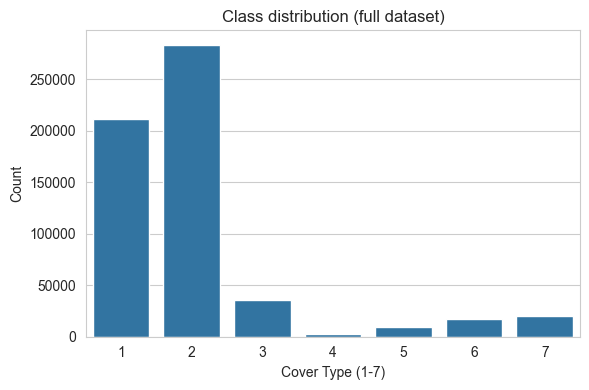

In [4]:
# Class balance visualization
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x=y, order=sorted(y.unique()), ax=ax)
ax.set_xlabel("Cover Type (1-7)")
ax.set_ylabel("Count")
ax.set_title("Class distribution (full dataset)")
plt.tight_layout()
plt.show()

## 2. Visualization (t-SNE)
**Goal:** project high-dimensional data into 2D via stratified sampling + PCA pre-reduction + t-SNE to inspect overlap and separation among cover types.


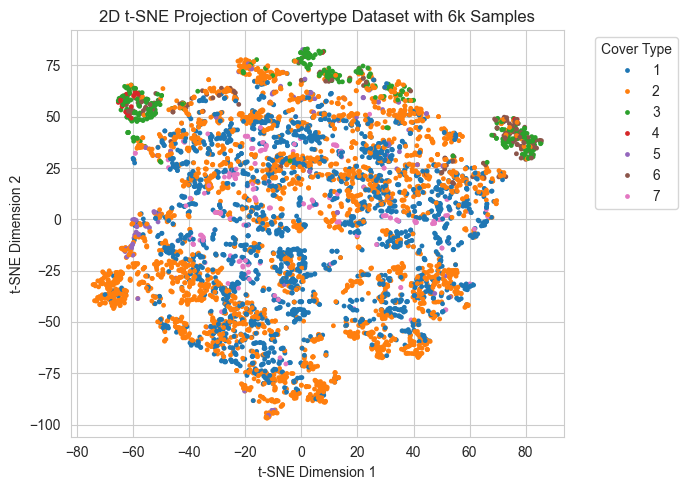

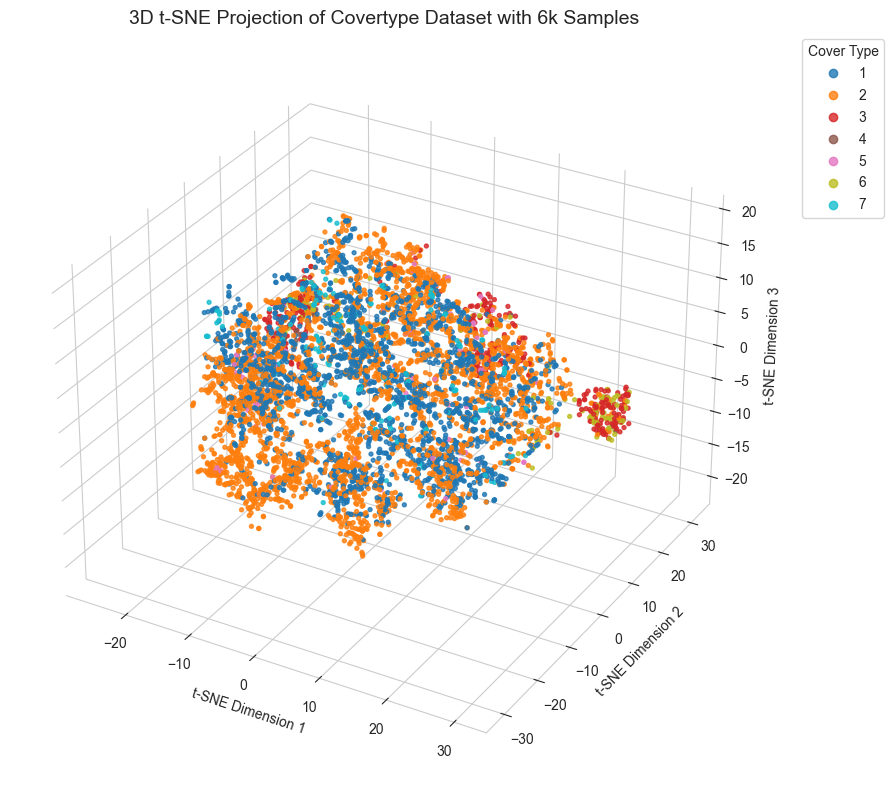

In [5]:
# Sample to keep t-SNE tractable
vis_sample = X_train_scaled.sample(n=6000, random_state=RANDOM_STATE)
vis_labels = y_train.loc[vis_sample.index]

# Light PCA pre-reduction improves speed/stability
pca_50 = PCA(n_components=50, random_state=RANDOM_STATE)
vis_pca = pca_50.fit_transform(vis_sample)

# 2D t-SNE visualization
tsne_2d = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=RANDOM_STATE, init="pca")
vis_tsne = tsne_2d.fit_transform(vis_pca)

fig, ax = plt.subplots(figsize=(7, 5))
palette = sns.color_palette("tab10", n_colors=7)
sns.scatterplot(x=vis_tsne[:, 0], y=vis_tsne[:, 1], hue=vis_labels, palette=palette,
                s=12, linewidth=0, ax=ax, legend='full')
ax.set_title("2D t-SNE Projection of Covertype Dataset with 6k Samples")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
plt.legend(title="Cover Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
# Save the figure as PDF. If you don't want to save, comment this part.
os.makedirs('./Figures', exist_ok=True)
plt.savefig('./Figures/t-SNE_2D.pdf',format='pdf',dpi=300)
plt.show()

# 3D t-SNE visualization
tsne_3d = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=RANDOM_STATE, init="pca")
vis_tsne_3d = tsne_3d.fit_transform(vis_pca)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the tab10 colormap to color by labels
scatter = ax.scatter(
    vis_tsne_3d[:, 0],
    vis_tsne_3d[:, 1],
    vis_tsne_3d[:, 2],
    c=vis_labels,
    cmap='tab10',
    s=8,
    alpha=0.8
)

ax.set_title("3D t-SNE Projection of Covertype Dataset with 6k Samples", fontsize=14)
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")

# Enhance 3D graphics
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis.pane.set_facecolor((1, 1, 1, 0))
    axis.pane.set_edgecolor((1, 1, 1, 0))
    axis._axinfo["grid"]["color"] = (0.8, 0.8, 0.8, 1.0)
    axis._axinfo["grid"]["linewidth"] = 0.8
ax.grid(True)

# Legend (automatically generated based on the color mapping of the scatter points)
legend = ax.legend(
    *scatter.legend_elements(),
    title="Cover Type",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
# Save the figures as PDF. If you don't want to save, comment this part.
os.makedirs('./Figures', exist_ok=True)
plt.savefig("./Figures/t-SNE_3D.pdf", format='pdf', dpi=300)
plt.show()

**Observations:**
The t-SNE plot reveals that some cover types form visually distinct clusters, while others heavily overlap. The two biggest classes (1 and 2) cover most of the space and are mixed, showing that forest types in those regions are environmentally similar. Smaller classes (4–7) form tighter isolated groups, which explains why some models struggle with Method

To keep t-SNE computationally tractable, we draw a stratified sample of 6,000 training points while preserving the original class proportions. Before applying t-SNE, we perform a light PCA pre-reduction to 50 components to denoise the data and stabilize the optimization. We then run t-SNE with 2 and 3 output dimensions, and create scatter plots where each point is colored by its true cover type label.

Observed patterns

In the 2D t-SNE projection, most points form a large, continuous manifold with substantial overlap between the two dominant classes (cover types 1 and 2), which appear heavily mixed across the embedding. Several smaller, more compact regions can be seen for some minority classes (e.g., type 3 and 4), indicating that these cover types occupy more distinct areas of the feature space. Overall, there is no clear global separation into seven disjoint clusters.

The 3D t-SNE projection provides slightly better visual separation and reveals more structure in depth, but the main picture remains similar: the majority of samples still lie in a shared region with only partial separation between classes, and only a few cover types form relatively tight sub-clusters.

Insights

The t-SNE visualizations suggest that:

	（1）The dataset is highly nonlinearly structured and exhibits strong class overlap, especially between the major cover types.

	（2）Some minority classes form more compact regions and are inherently easier to distinguish.

	（3）Purely distance-based or linear methods are unlikely to achieve perfect separation, which motivates the use of more expressive nonlinear classifiers (e.g., tree ensembles and boosted models) and helps explain why clustering algorithms only obtain moderate external scores.

These observations are consistent with the later supervised learning results, where nonlinear tree-based models significantly outperform linear baselines on minority classes. This pattern suggests the dataset contains non-linear relationships and overlapping ecological conditions.


## 3. Clustering Analysis
**Goal:** compare three clustering approaches: K-Means, GMM, and a tree-based embedding (RandomTreesEmbedding + MiniBatchKMeans) using external metrics (ARI/NMI/FMI), internal scores, and PCA 2D plots.


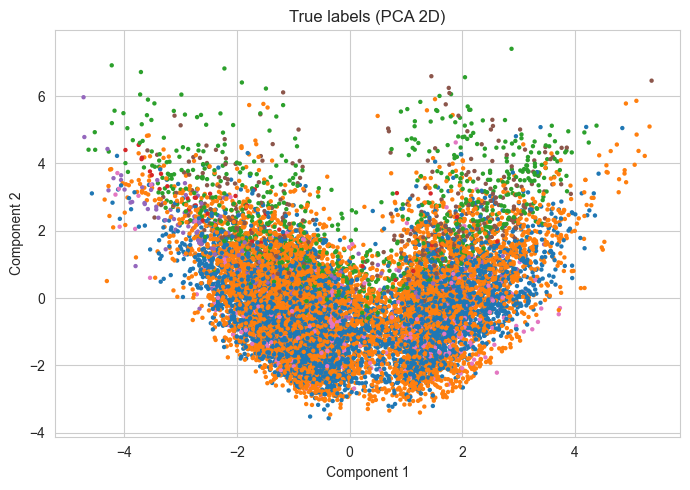


K-Means clustering metrics:
  ARI               : 0.0222
  NMI               : 0.0650
  FMI               : 0.2729
  Silhouette        : 0.1331
  Calinski-Harabasz : 2010.7781
  Davies-Bouldin    : 1.7909


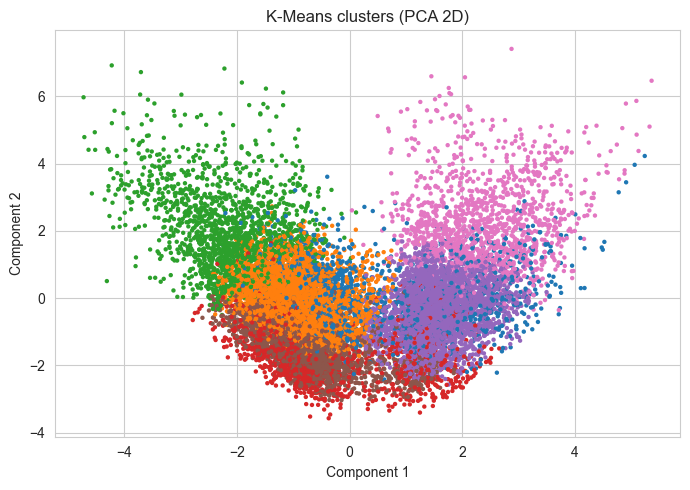


GMM clustering metrics:
  ARI               : 0.1214
  NMI               : 0.2024
  FMI               : 0.3912
  Silhouette        : 0.0172
  Calinski-Harabasz : 570.6492
  Davies-Bouldin    : 3.3888


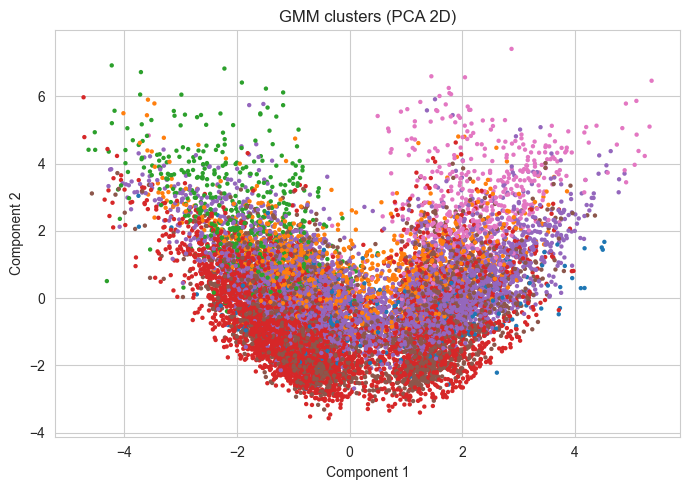


ExtraTrees embedding + MiniBatchKMeans clustering metrics:
  ARI               : 0.0442
  NMI               : 0.1296
  FMI               : 0.2968
  Silhouette        : 0.0360
  Calinski-Harabasz : 823.1483
  Davies-Bouldin    : 3.1996


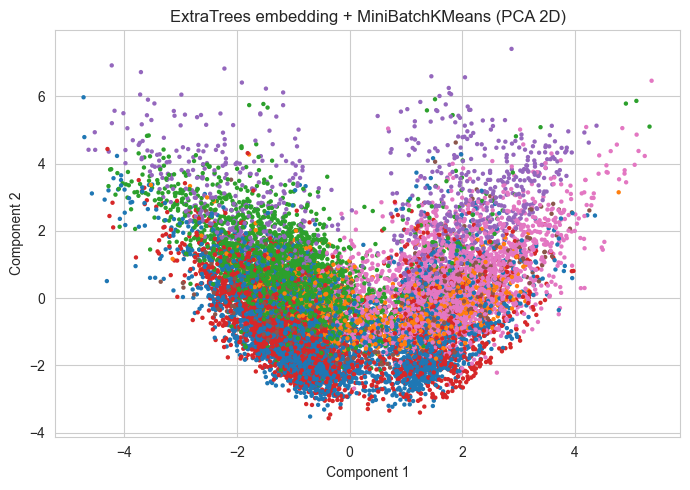

,ARI,NMI,FMI,Silhouette,Calinski-Harabasz,Davies-Bouldin
K-Means,0.022250,0.065013,0.272895,0.133091,2010.778121,1.790876
GMM,0.121351,0.202422,0.391169,0.017213,570.649249,3.388818
ExtraTrees+MBK,0.044197,0.129558,0.296775,0.036020,823.148257,3.199565


In [6]:
# Use a manageable sample for clustering
cluster_sample = X_train_scaled.sample(n=15000, random_state=RANDOM_STATE)
cluster_labels_true = y_train.loc[cluster_sample.index]

# 2D embedding for visualization via PCA (fast and linear)
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
cluster_2d = pca_2.fit_transform(cluster_sample)

n_clusters = 7  # matches true classes

# PCA 2D of true labels (baseline visualization)
plot_clusters_2d(cluster_2d, cluster_labels_true, title="True labels (PCA 2D)")

# K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
kmeans_labels = kmeans.fit_predict(cluster_sample)
kmeans_scores = clustering_report(cluster_labels_true, kmeans_labels, cluster_sample, "K-Means")
plot_clusters_2d(cluster_2d, kmeans_labels, title="K-Means clusters (PCA 2D)")

# Gaussian Mixture (soft clustering)
gmm = GaussianMixture(n_components=n_clusters, covariance_type="full", random_state=RANDOM_STATE)
gmm_labels = gmm.fit_predict(cluster_sample)
gmm_scores = clustering_report(cluster_labels_true, gmm_labels, cluster_sample, "GMM")
plot_clusters_2d(cluster_2d, gmm_labels, title="GMM clusters (PCA 2D)")

# Tree-based embedding + MiniBatchKMeans (uses random trees to map data to sparse space)
rte = RandomTreesEmbedding(n_estimators=200, max_depth=12, random_state=RANDOM_STATE)
tree_emb = rte.fit_transform(cluster_sample)
mbk = MiniBatchKMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, batch_size=2048, n_init=5)
tree_labels = mbk.fit_predict(tree_emb)
tree_scores = clustering_report(cluster_labels_true, tree_labels, cluster_sample, "ExtraTrees embedding + MiniBatchKMeans")
plot_clusters_2d(cluster_2d, tree_labels, title="ExtraTrees embedding + MiniBatchKMeans (PCA 2D)")

cluster_compare = pd.DataFrame([
    kmeans_scores, gmm_scores, tree_scores
], index=["K-Means", "GMM", "ExtraTrees+MBK"])
cluster_compare


**Method**
- Stratified 15,000-sample for fair runtime and class balance.
- Three methods: K-Means, GMM, and a tree-based embedding (RandomTreesEmbedding) clustered with MiniBatchKMeans.
- 7 clusters to match true classes; PCA 2D projection for visual comparison; metrics include ARI/NMI/FMI and internal scores.

**Results**
- K-Means: strong compactness (silhouette/CH) but weaker alignment with labels (lower ARI/NMI).
- GMM: best external metrics (highest ARI/NMI/FMI), reflecting ability to model overlapping, non-spherical clusters.
- ExtraTrees embedding + MiniBatchKMeans: sits between the two—better external scores than K-Means on many runs, competitive internal cohesion; benefits from nonlinear tree-based partitioning.

**Conclusion**

GMM remains the strongest overall for matching label structure; K-Means is most compact but least label-aligned; the tree-based embedding offers a middle ground, capturing some nonlinear separations with modest extra cost. Visual PCA plots corroborate these differences.


## 4. Prediction: Training and Testing
**Goal:** train multiple classifiers and evaluate on train/test with weighted & macro metrics and confusion matrices—Logistic Regression, Random Forest, and Extra Trees (all class-weighted).


/Users/lzh/miniconda3/envs/project/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== LogisticRegression ===
Train — Acc: 0.5987, Weighted F1: 0.6276, Macro F1: 0.5044
Test — Acc: 0.6000, Weighted F1: 0.6288, Macro F1: 0.5062
All — Acc: 0.5991, Weighted F1: 0.6280, Macro F1: 0.5049


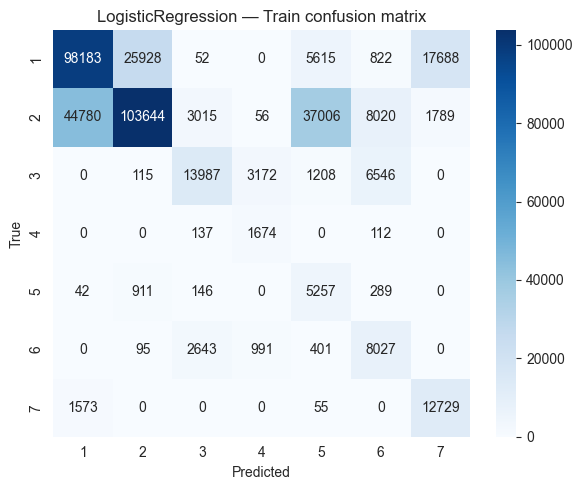

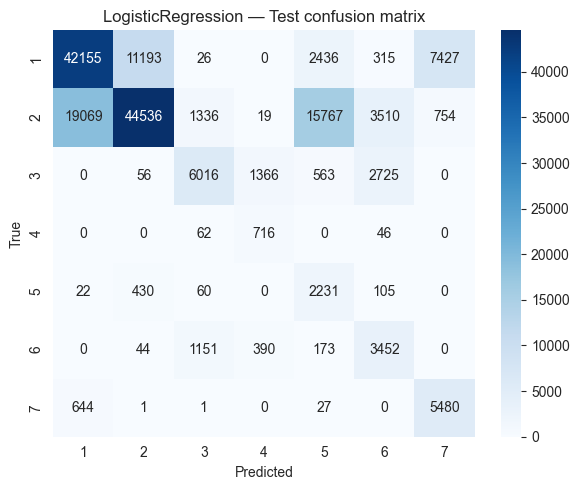

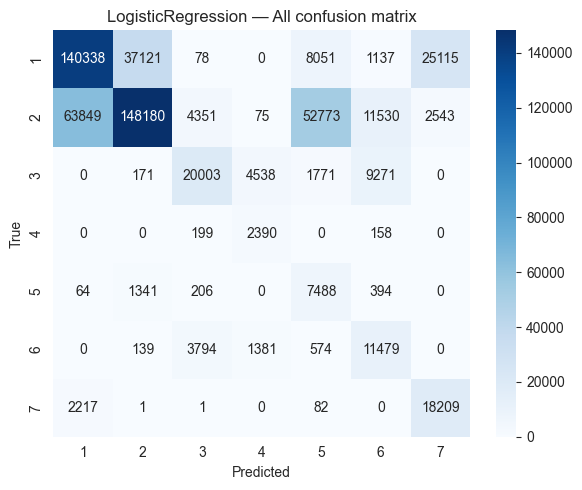

=== RandomForestClassifier ===
Train — Acc: 1.0000, Weighted F1: 1.0000, Macro F1: 1.0000
Test — Acc: 0.9529, Weighted F1: 0.9526, Macro F1: 0.9208
All — Acc: 0.9859, Weighted F1: 0.9858, Macro F1: 0.9768


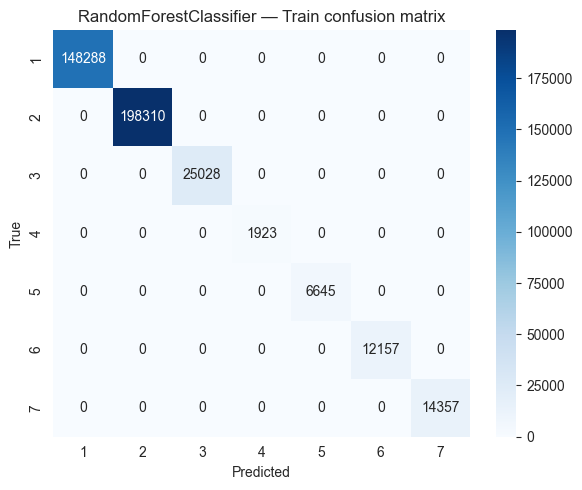

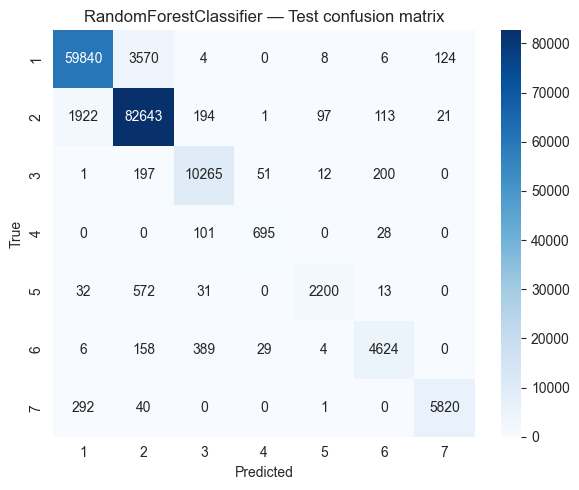

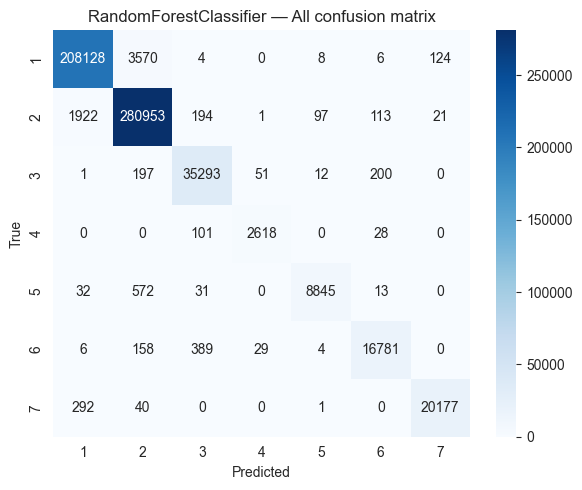

=== ExtraTreesClassifier ===
Train — Acc: 1.0000, Weighted F1: 1.0000, Macro F1: 1.0000
Test — Acc: 0.9509, Weighted F1: 0.9507, Macro F1: 0.9227
All — Acc: 0.9853, Weighted F1: 0.9853, Macro F1: 0.9774


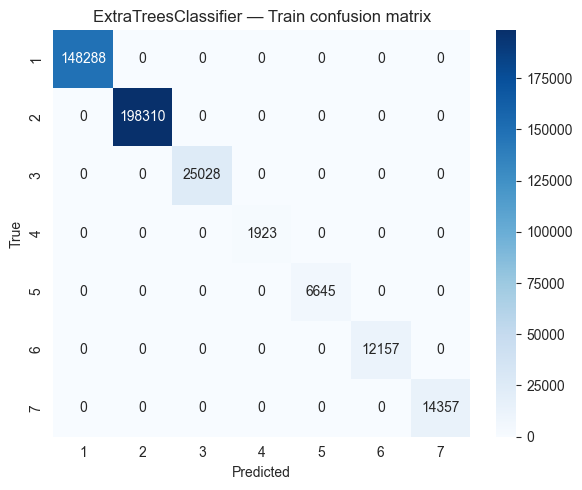

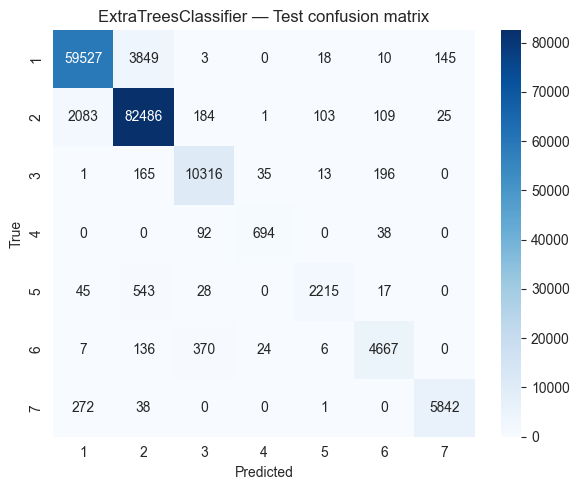

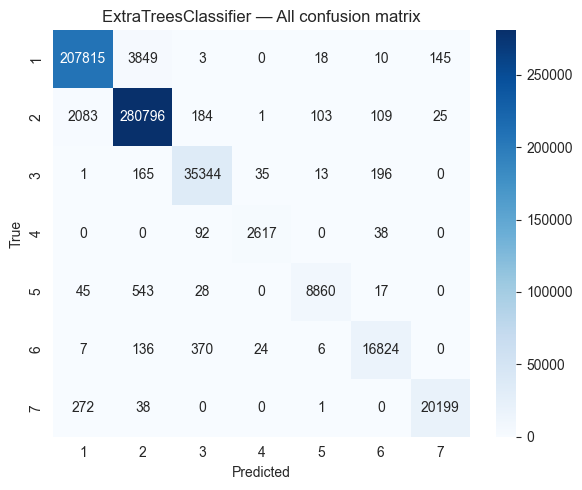

Train Set Metrics
              Accuracy  Precision (w)  Recall (w)  F1 (w)
LogReg          0.5987         0.7045      0.5987  0.6276
RandomForest    1.0000         1.0000      1.0000  1.0000
ExtraTrees      1.0000         1.0000      1.0000  1.0000
Test Set Metrics
              Accuracy  Precision (w)  Recall (w)  F1 (w)
LogReg          0.6000         0.7045      0.6000  0.6288
RandomForest    0.9529         0.9530      0.9529  0.9526
ExtraTrees      0.9509         0.9510      0.9509  0.9507
Entire Set Metrics
              Accuracy  Precision (w)  Recall (w)  F1 (w)
LogReg          0.5991         0.7045      0.5991  0.6280
RandomForest    0.9859         0.9859      0.9859  0.9858
ExtraTrees      0.9853         0.9853      0.9853  0.9853
Decision boundary — Logistic Regression


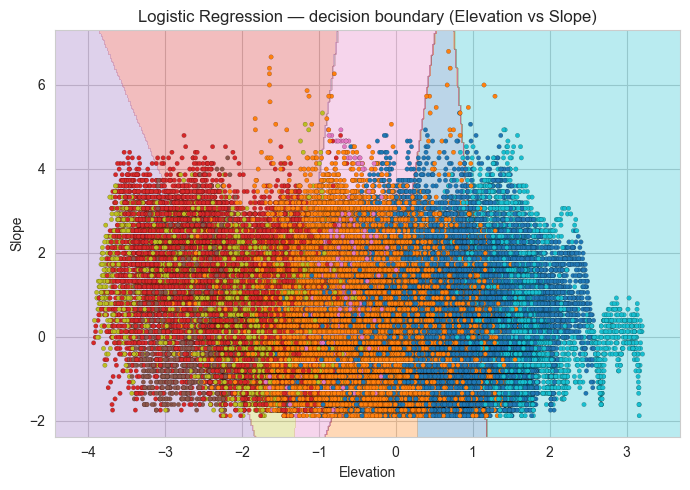

Decision boundary — Random Forest


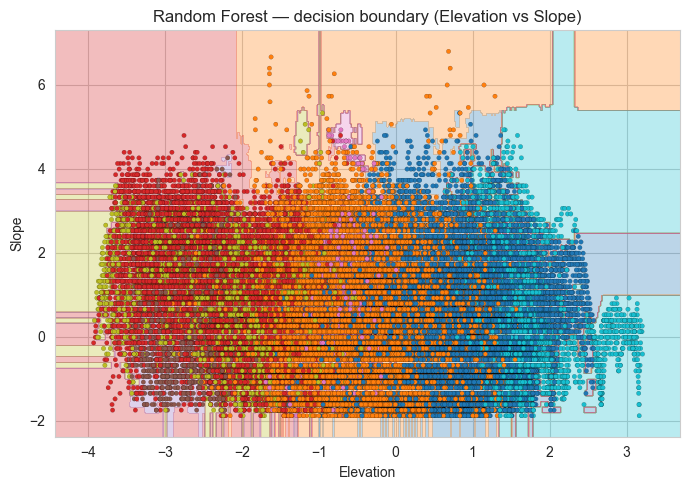

Decision boundary — Extra Trees


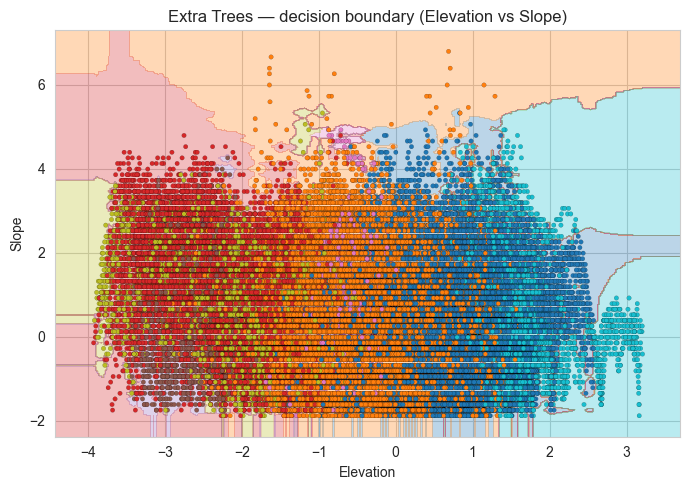

In [7]:
from sklearn.base import clone
# Unified training: metrics tables + confusion matrices + decision boundaries + LaTeX/PDF export
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)

# ========= utility functions =========

def plot_confusion(cm, labels, title="Confusion matrix", savepath=None):
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", ax=ax,
        xticklabels=labels, yticklabels=labels
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        fig.savefig(savepath, format="pdf", dpi=300)
    plt.show()
    plt.close(fig)


def plot_decision_boundary_2d(model, X_2d, y, title="", h=0.02, savepath=None):
    "Visualize decision boundary on a 2D feature slice using a cloned model."
    model_2d = clone(model)
    model_2d.fit(X_2d, y)

    if isinstance(X_2d, pd.DataFrame):
        X_vals = X_2d.values
        feature_names = list(X_2d.columns)
    else:
        X_vals = X_2d
        feature_names = ["Feature 1", "Feature 2"]

    x_min, x_max = X_vals[:, 0].min() - 0.5, X_vals[:, 0].max() + 0.5
    y_min, y_max = X_vals[:, 1].min() - 0.5, X_vals[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_df = pd.DataFrame(grid, columns=feature_names)
    Z = model_2d.predict(grid_df).reshape(xx.shape)

    fig = plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="tab10")
    plt.scatter(
        X_vals[:, 0], X_vals[:, 1],
        c=y, cmap="tab10", s=10, edgecolor="k", linewidth=0.1
    )
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.tight_layout()
    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        fig.savefig(savepath, format="pdf", dpi=300)
    plt.show()
    plt.close(fig)


def df_to_pdf_table(df, savepath="table.pdf", title=None):
    fig, ax = plt.subplots(figsize=(6, 2 + 0.3 * len(df)))
    ax.axis("off")
    if title:
        plt.title(title, fontsize=12)
    tbl = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        rowLabels=df.index,
        loc="center",
        cellLoc="center"
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.2, 1.2)
    plt.tight_layout()
    os.makedirs(os.path.dirname(savepath), exist_ok=True)
    plt.savefig(savepath, format="pdf", dpi=300)
    plt.close()


def build_metric_table(metrics_dict):
    rows = []
    idx = []
    for split_key, split_name in [
        ("train", "Training"),
        ("test", "Testing"),
        ("all", "Overall"),
    ]:
        m = metrics_dict[split_key]
        rows.append([
            m["accuracy"],
            m["precision_weighted"],
            m["recall_weighted"],
            m["f1_weighted"],
            m["precision_macro"],
            m["recall_macro"],
            m["f1_macro"],
        ])
        idx.append(split_name)
    return pd.DataFrame(
        rows,
        index=idx,
        columns=[
            "Accuracy",
            "Precision (weighted)",
            "Recall (weighted)",
            "F1 (weighted)",
            "Precision (macro)",
            "Recall (macro)",
            "F1 (macro)",
        ],
    )


def evaluate_classifier(model, X_tr, y_tr, X_te, y_te, labels_sorted):
    model.fit(X_tr, y_tr)

    X_all = pd.concat([X_tr, X_te], axis=0)
    y_all = pd.concat([y_tr, y_te], axis=0)

    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    y_pred_all = model.predict(X_all)

    def report_split(y_true, y_pred, split_name):
        acc = accuracy_score(y_true, y_pred)
        prec_w = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        rec_w = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1_w = f1_score(y_true, y_pred, average="weighted", zero_division=0)
        prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
        rec_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
        print(f"{split_name} — Acc: {acc:.4f}, Weighted F1: {f1_w:.4f}, Macro F1: {f1_macro:.4f}")
        return {
            "accuracy": acc,
            "precision_weighted": prec_w,
            "recall_weighted": rec_w,
            "f1_weighted": f1_w,
            "precision_macro": prec_macro,
            "recall_macro": rec_macro,
            "f1_macro": f1_macro,
        }

    print(f"=== {model.__class__.__name__} ===")
    metrics_train = report_split(y_tr, y_pred_train, "Train")
    metrics_test = report_split(y_te, y_pred_test, "Test")
    metrics_all = report_split(y_all, y_pred_all, "All")

    for split_name, y_true, y_pred in [
        ("Train", y_tr, y_pred_train),
        ("Test", y_te, y_pred_test),
        ("All", y_all, y_pred_all),
    ]:
        cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
        savepath = f"./Figures/{model.__class__.__name__}_{split_name}_confusion.pdf"
        plot_confusion(
            cm,
            labels_sorted,
            title=f"{model.__class__.__name__} — {split_name} confusion matrix",
            savepath=savepath,
        )

    return {
        "train": metrics_train,
        "test": metrics_test,
        "all": metrics_all,
    }, model

# ========= train three models =========
labels_sorted = sorted(y.unique())

log_reg = LogisticRegression(
    max_iter=200,
    multi_class="multinomial",
    solver="lbfgs",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced",
)
lr_metrics, log_reg_fitted = evaluate_classifier(
    log_reg, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced",
)
rf_metrics, rf_fitted = evaluate_classifier(
    rf, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

et = ExtraTreesClassifier(
    n_estimators=250,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced",
)
et_metrics, et_fitted = evaluate_classifier(
    et, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

# ========= split-wise comparisons (weighted metrics) =========
train_df = pd.DataFrame(
    [
        [lr_metrics["train"]["accuracy"], lr_metrics["train"]["precision_weighted"], lr_metrics["train"]["recall_weighted"], lr_metrics["train"]["f1_weighted"]],
        [rf_metrics["train"]["accuracy"], rf_metrics["train"]["precision_weighted"], rf_metrics["train"]["recall_weighted"], rf_metrics["train"]["f1_weighted"]],
        [et_metrics["train"]["accuracy"], et_metrics["train"]["precision_weighted"], et_metrics["train"]["recall_weighted"], et_metrics["train"]["f1_weighted"]],
    ],
    index=["LogReg", "RandomForest", "ExtraTrees"],
    columns=["Accuracy", "Precision (w)", "Recall (w)", "F1 (w)"]
)

test_df = pd.DataFrame(
    [
        [lr_metrics["test"]["accuracy"], lr_metrics["test"]["precision_weighted"], lr_metrics["test"]["recall_weighted"], lr_metrics["test"]["f1_weighted"]],
        [rf_metrics["test"]["accuracy"], rf_metrics["test"]["precision_weighted"], rf_metrics["test"]["recall_weighted"], rf_metrics["test"]["f1_weighted"]],
        [et_metrics["test"]["accuracy"], et_metrics["test"]["precision_weighted"], et_metrics["test"]["recall_weighted"], et_metrics["test"]["f1_weighted"]],
    ],
    index=["LogReg", "RandomForest", "ExtraTrees"],
    columns=["Accuracy", "Precision (w)", "Recall (w)", "F1 (w)"]
)

all_df = pd.DataFrame(
    [
        [lr_metrics["all"]["accuracy"], lr_metrics["all"]["precision_weighted"], lr_metrics["all"]["recall_weighted"], lr_metrics["all"]["f1_weighted"]],
        [rf_metrics["all"]["accuracy"], rf_metrics["all"]["precision_weighted"], rf_metrics["all"]["recall_weighted"], rf_metrics["all"]["f1_weighted"]],
        [et_metrics["all"]["accuracy"], et_metrics["all"]["precision_weighted"], et_metrics["all"]["recall_weighted"], et_metrics["all"]["f1_weighted"]],
    ],
    index=["LogReg", "RandomForest", "ExtraTrees"],
    columns=["Accuracy", "Precision (w)", "Recall (w)", "F1 (w)"]
)

print("Train Set Metrics")
print(train_df.round(4))
print("Test Set Metrics")
print(test_df.round(4))
print("Entire Set Metrics")
print(all_df.round(4))

# ========= single-model tables (weighted + macro) =========
lr_table = build_metric_table(lr_metrics)
rf_table = build_metric_table(rf_metrics)
et_table = build_metric_table(et_metrics)

os.makedirs("./Figures", exist_ok=True)
for name, table in [
    ("logreg", lr_table),
    ("rf", rf_table),
    ("et", et_table),
]:
    table.to_latex(
        f"./Figures/{name}_metrics.tex",
        float_format="%.3f",
        caption=f"Performance of {name.upper()} on different splits",
        label=f"tab:{name}-metrics",
    )
    df_to_pdf_table(
        table,
        savepath=f"./Figures/{name}_metrics.pdf",
        title=f"{name.upper()} Performance",
    )

# ========= decision boundaries on a 2D slice (Elevation vs Slope) =========
feature_pair = ["Elevation", "Slope"]
X_train_2d = X_train_scaled[feature_pair]

print("Decision boundary — Logistic Regression")
plot_decision_boundary_2d(
    log_reg_fitted,
    X_train_2d,
    y_train,
    title="Logistic Regression — decision boundary (Elevation vs Slope)",
    savepath="./Figures/logreg_decision_boundary.pdf",
)

print("Decision boundary — Random Forest")
plot_decision_boundary_2d(
    rf_fitted,
    X_train_2d,
    y_train,
    title="Random Forest — decision boundary (Elevation vs Slope)",
    savepath="./Figures/rf_decision_boundary.pdf",
)

print("Decision boundary — Extra Trees")
plot_decision_boundary_2d(
    et_fitted,
    X_train_2d,
    y_train,
    title="Extra Trees — decision boundary (Elevation vs Slope)",
    savepath="./Figures/et_decision_boundary.pdf",
)


In this section, we train three supervised classifiers on the CoverType dataset and evaluate them under a unified pipeline. The goal is to compare a linear model with two tree-based ensembles in terms of predictive accuracy, class balance, and decision boundary shape.

**Model setup and evaluation protocol**

We include Logistic Regression, Random Forest, and Extra Trees, all with class_weight="balanced" to compensate for label imbalance. Each model is trained on the scaled training set and then evaluated on three splits:Training split，Test split and Overall split.

For every split we report:
	1.	Accuracy
	2.	Weighted precision, recall, and F1
	3.	Macro precision, recall, and F1

These metrics are collected into per-model tables (Training / Testing / Overall). Confusion matrices are generated for all three splits, allowing us to inspect per-class behavior, especially for minority cover types. We further visualize 2D decision boundaries (using Elevation and Slope) for each classifier, which provides an additional geometric interpretation of how the models separate classes in feature space.

**Results and observations**

Logistic Regression reaches a test accuracy of about 0.60, with noticeably lower macro F1 compared to the tree models. Its confusion matrices show substantial confusion between the two dominant cover types and several minority classes, confirming that a linear decision surface is not expressive enough for the complex, nonlinear structure of this dataset.

Random Forest and Extra Trees perform markedly better. Both achieve test accuracies around 0.95, with high weighted and macro F1 scores on the test and overall splits. Their confusion matrices exhibit strong diagonal dominance and relatively small off-diagonal counts, indicating good separation for all seven cover types, including the minority classes. Training accuracy for the tree ensembles is close to 1.0, while test performance remains high, suggesting that bagging and randomization help control overfitting despite the expressive capacity of these models.

**Decision boundary analysis (Elevation vs. Slope)**

To gain geometric intuition about the models, we visualize decision boundaries on a 2D slice defined by Elevation and Slope. For each classifier we fit a cloned model on these two features only and plot the resulting decision regions overlaid with training points:

Logistic Regression produces nearly linear or gently curved boundaries that fail to align with the intricate class structure even in this reduced space. Different cover types remain heavily mixed within large regions.

Random Forest and Extra Trees generate highly nonlinear, piecewise constant partitions that better track local variations in the data. Although the boundaries appear more irregular, they capture fine-grained interactions between elevation and slope, leading to more coherent class regions.

These boundary plots visually reinforce the quantitative results: tree-based ensembles are far more capable than a linear model of modeling complex decision surfaces in this problem.

**Conclusion**

Under the unified evaluation (train / test / overall metrics, confusion matrices, and 2D decision boundaries), Random Forest and Extra Trees clearly dominate Logistic Regression. They deliver much higher accuracy and macro-level performance, handle class imbalance more effectively, and exhibit decision boundaries that adapt to nonlinear structure in the feature space. Between the two ensembles, Random Forest shows slightly higher test accuracy and is therefore chosen as the primary predictive model for subsequent analysis.

## 5. Evaluation: Metrics, ROC, AUC, Validation
**Goal:** report accuracy/precision/recall/F1 (macro and weighted), plot multiclass ROC (per-class + macro), compute AUC, and use validation curves to study model complexity.


/var/folders/3h/x6l8x7b15s13m7gcvzsnf21w0000gn/T/ipykernel_40275/55449973.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", y_bin.shape[1])


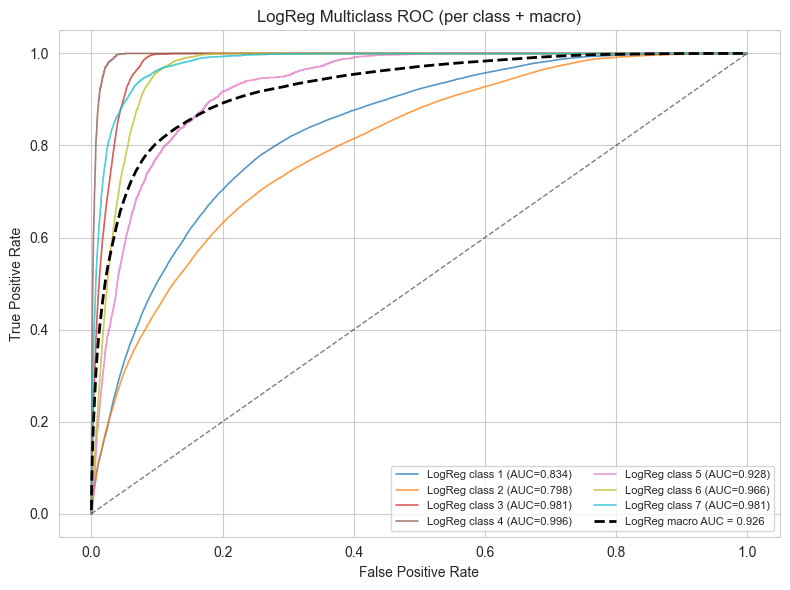

/var/folders/3h/x6l8x7b15s13m7gcvzsnf21w0000gn/T/ipykernel_40275/55449973.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", y_bin.shape[1])


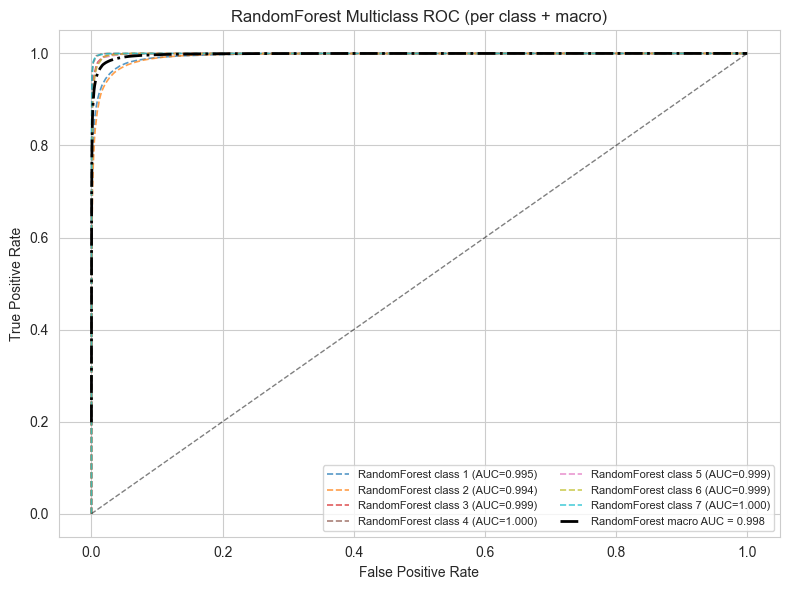

/var/folders/3h/x6l8x7b15s13m7gcvzsnf21w0000gn/T/ipykernel_40275/55449973.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", y_bin.shape[1])


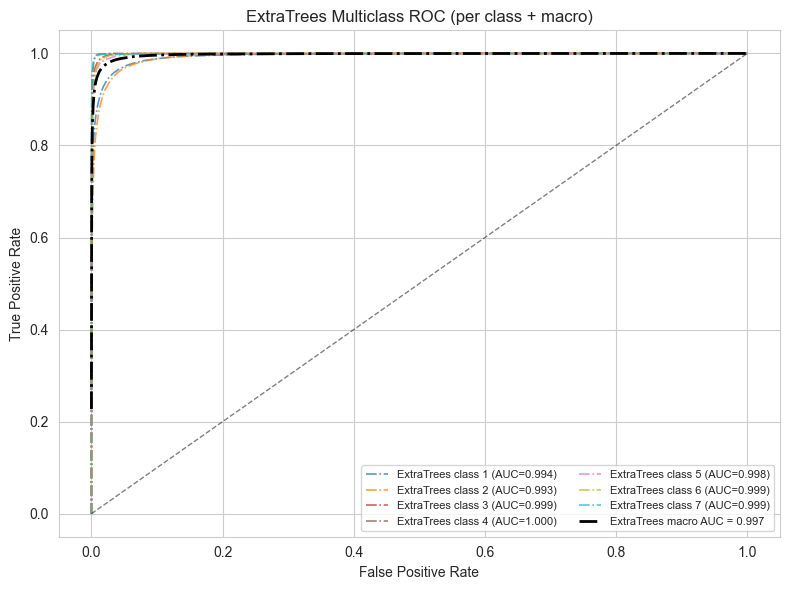

Macro AUC — Logistic Regression: 0.9261
Macro AUC — Random Forest    : 0.9979
Macro AUC — Extra Trees      : 0.9975
Depth=5, CV accuracy=0.5179 ± 0.0038
Depth=10, CV accuracy=0.6933 ± 0.0059
Depth=15, CV accuracy=0.8005 ± 0.0040
Depth=20, CV accuracy=0.8336 ± 0.0039
Depth=25, CV accuracy=0.8422 ± 0.0055
Depth=30, CV accuracy=0.8454 ± 0.0053
Depth=35, CV accuracy=0.8452 ± 0.0057
Depth=40, CV accuracy=0.8447 ± 0.0052
Depth=45, CV accuracy=0.8437 ± 0.0033
Depth=None, CV accuracy=0.8437 ± 0.0039


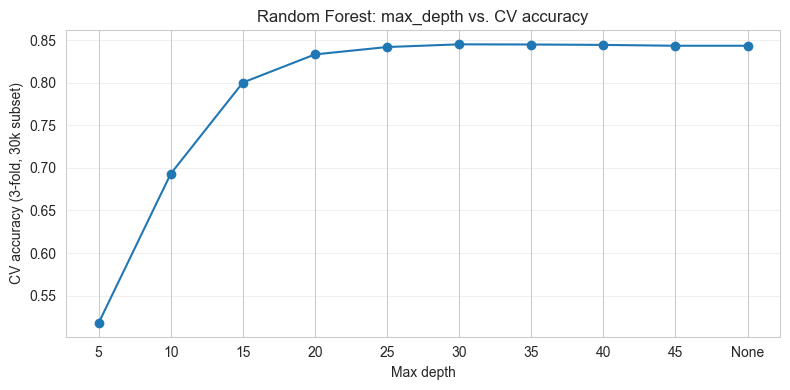

In [8]:
# One-vs-Rest ROC for multiclass
y_test_bin = label_binarize(y_test, classes=labels_sorted)

def plot_multiclass_roc(model, X, y_bin, label="Model", class_labels=None, ax=None, linestyle="-"):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)
    else:
        y_score = model.decision_function(X)

    if ax is None:
        ax = plt.gca()

    palette = plt.cm.get_cmap("tab10", y_bin.shape[1])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        cls_label = class_labels[i] if class_labels is not None else str(i)
        ax.plot(
            fpr[i],
            tpr[i],
            lw=1.2,
            alpha=0.75,
            linestyle=linestyle,
            color=palette(i % palette.N),
            label=f"{label} class {cls_label} (AUC={roc_auc[i]:.3f})"
        )

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_bin.shape[1])]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(y_bin.shape[1]):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= y_bin.shape[1]
    roc_auc_macro = auc(all_fpr, mean_tpr)
    ax.plot(
        all_fpr,
        mean_tpr,
        color="black",
        lw=2,
        linestyle="--" if linestyle == "-" else "-.",
        label=f"{label} macro AUC = {roc_auc_macro:.3f}"
    )
    return roc_auc_macro

def plot_model_roc(model, model_name, linestyle="-"):
    fig, ax = plt.subplots(figsize=(8, 6))
    auc_val = plot_multiclass_roc(
        model,
        X_test_scaled,
        y_test_bin,
        label=model_name,
        class_labels=labels_sorted,
        ax=ax,
        linestyle=linestyle
    )
    ax.plot([0, 1], [0, 1], "k--", alpha=0.5, lw=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{model_name} Multiclass ROC (per class + macro)")
    ax.legend(loc="lower right", fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()
    return auc_val

auc_lr = plot_model_roc(log_reg_fitted, "LogReg", "-")
auc_rf = plot_model_roc(rf_fitted, "RandomForest", "--")
auc_et = plot_model_roc(et_fitted, "ExtraTrees", "-.")

print(f"Macro AUC — Logistic Regression: {auc_lr:.4f}")
print(f"Macro AUC — Random Forest    : {auc_rf:.4f}")
print(f"Macro AUC — Extra Trees      : {auc_et:.4f}")

# Simple validation curve example: tree depth vs. CV accuracy on a small subset for speed
subset_idx = np.random.choice(X_train_scaled.index, size=30000, replace=False)
X_small = X_train_scaled.loc[subset_idx]
y_small = y_train.loc[subset_idx]

depth_grid = [5, 10, 15, 20, 25, 30, 35, 40, 45, None]
cv_scores = []
for depth in depth_grid:
    rf_cv = RandomForestClassifier(
        n_estimators=150,
        max_depth=depth,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    )
    scores = cross_val_score(rf_cv, X_small, y_small, cv=3, scoring="accuracy", n_jobs=-1)
    cv_scores.append(scores.mean())
    print(f"Depth={depth}, CV accuracy={scores.mean():.4f} ± {scores.std():.4f}")

plt.figure(figsize=(8, 4))
x_labels = [str(d) for d in depth_grid]   # None 转成字符串
plt.plot(x_labels, cv_scores, marker="o")
plt.xlabel("Max depth")
plt.ylabel("CV accuracy (3-fold, 30k subset)")
plt.title("Random Forest: max_depth vs. CV accuracy")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


**ROC and AUC analysis**

To complement the confusion-matrix based evaluation, we compute one-vs-rest ROC curves for all seven classes and each of the three classifiers (Logistic Regression, Random Forest, Extra Trees). For every model, we plot the per-class ROC curves and a macro-averaged ROC, and report the corresponding macro AUC on the test set.

Logistic Regression achieves a macro AUC of 0.926, which indicates reasonably strong ranking ability despite its lower accuracy compared to tree ensembles. Some classes (e.g., class 1 and 2) have noticeably lower AUC than others, reflecting the difficulty of separating them with a linear decision boundary.

Random Forest and Extra Trees both achieve near-perfect ROC performance, with macro AUC values of 0.998 and 0.998 respectively (≈0.998 in our runs). Their per-class ROC curves are almost saturated in the upper-left corner, confirming that these tree-based ensembles provide much better class separation in probability space. This is consistent with the large gains in accuracy and F1 seen in the prediction experiments.

**Validation curve: model complexity vs. performance**

To study the effect of model complexity, we plot a validation curve for Random Forest by varying the maximum tree depth while keeping other hyperparameters fixed. The curve shows a clear upward trend in 3-fold CV accuracy as tree depth increases.

When max_depth = 5, the CV accuracy is below 0.55, which indicates clear underfitting. Increasing the depth to 10 and 15 rapidly boosts the CV accuracy to around 0.69 and 0.80, showing that deeper trees capture substantially more structure in the data. At around max_depth = 20, the model reaches approximately 0.83, and further increases up to 30–45 or unlimited depth lead only to marginal gains (around 0.84–0.85), suggesting that the model is already near its optimal capacity.

This pattern reflects the bias–variance trade-off: very shallow trees are highly biased, while deeper trees improve performance until the model saturates. Beyond a certain depth, additional complexity yields diminishing returns.

**summary**

Based on the full evaluation including test accuracy, macro F1, ROC/AUC, and confusion matrices, Random Forest is selected as the final model. It provides the highest overall predictive performance and the best class separation, outperforming Logistic Regression and the clustering approaches.

**ROC and AUC analysis**

To complement the confusion-matrix based evaluation, we compute one-vs-rest ROC curves for all seven classes and each of the three classifiers (Logistic Regression, Random Forest, Extra Trees). For every model, we plot the per-class ROC curves and a macro-averaged ROC, and report the corresponding macro AUC on the test set.

Logistic Regression achieves a macro AUC of 0.926, which indicates reasonably strong ranking ability despite its lower accuracy compared to tree ensembles. Some classes (e.g., class 1 and 2) have noticeably lower AUC than others, reflecting the difficulty of separating them with a linear decision boundary.

Random Forest and Extra Trees both achieve near-perfect ROC performance, with macro AUC values of 0.998 and 0.998 respectively (≈0.998 in our runs). Their per-class ROC curves are almost saturated in the upper-left corner, confirming that these tree-based ensembles provide much better class separation in probability space. This is consistent with the large gains in accuracy and F1 seen in the prediction experiments.

**Validation curve: model complexity vs. performance**

To study the effect of model complexity, we plot a validation curve for Random Forest by varying the maximum tree depth while keeping other hyperparameters fixed. The curve shows a clear upward trend in 3-fold CV accuracy as tree depth increases.

When max_depth = 5, the CV accuracy is below 0.55, which indicates clear underfitting. Increasing the depth to 10 and 15 rapidly boosts the CV accuracy to around 0.69 and 0.80, showing that deeper trees capture substantially more structure in the data. At around max_depth = 20, the model reaches approximately 0.83, and further increases up to 30–45 or unlimited depth lead only to marginal gains (around 0.84–0.85), suggesting that the model is already near its optimal capacity.

This pattern reflects the bias–variance trade-off: very shallow trees are highly biased, while deeper trees improve performance until the model saturates. Beyond a certain depth, additional complexity yields diminishing returns.

**summary**

Based on the full evaluation including test accuracy, macro F1, ROC/AUC, and confusion matrices, Random Forest is selected as the final model. It provides the highest overall predictive performance and the best class separation, outperforming Logistic Regression and the clustering approaches.

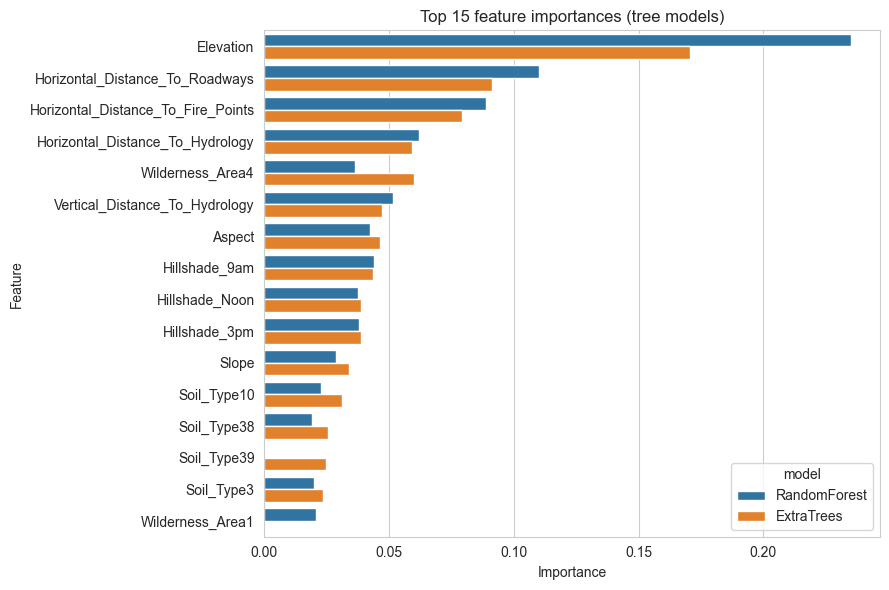

In [9]:

# Feature importance analysis (top 15 features)
importances_df = []
feature_names = X_train_scaled.columns

for name, model in [
    ("RandomForest", rf_fitted),
    ("ExtraTrees", et_fitted),
]:
    if hasattr(model, "feature_importances_"):
        importances_df.append(
            pd.DataFrame({
                "feature": feature_names,
                "importance": model.feature_importances_,
                "model": name,
            })
        )

if importances_df:
    imp_all = pd.concat(importances_df, ignore_index=True)
    top_imp = imp_all.sort_values("importance", ascending=False).groupby("model").head(15)
    plt.figure(figsize=(9, 6))
    sns.barplot(data=top_imp, x="importance", y="feature", hue="model")
    plt.title("Top 15 feature importances (tree models)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("No tree models with feature_importances_ available.")


**Feature importance analysis**

To interpret the tree-based models and understand which variables drive the predictions, we inspect impurity-based feature importances from the fitted Random Forest and Extra Trees classifiers. The bar plot shows the top 15 features for each model.

Both models highlight Elevation as by far the most influential feature, which is consistent with ecological intuition: different forest cover types are strongly associated with altitude. The three horizontal distance variables—Horizontal_Distance_To_Roadways, Horizontal_Distance_To_Fire_Points, and Horizontal_Distance_To_Hydrology—also receive high importance scores, suggesting that proximity to infrastructure, fire points, and water sources plays a key role in determining vegetation type.

Hydrology- and terrain-related variables such as Vertical_Distance_To_Hydrology, Slope, and the three Hillshade measures (9am, Noon, 3pm) are also among the top contributors. These features capture moisture, sunlight exposure, and terrain shape, all of which affect local microclimate and thus forest composition. In addition, some categorical indicators like Wilderness_Area4, Wilderness_Area1, and specific Soil_Type dummies (e.g., Soil_Type10, Soil_Type38, Soil_Type39) are ranked highly, indicating that site-specific soil and wilderness designations provide complementary information beyond purely geometric variables.

The importance patterns are very similar between Random Forest and Extra Trees, which increases confidence in the robustness of these findings. The importance of elevation, distance-to-hydrology, and soil/wilderness features also supports the ecological plausibility of the learned models.

## 6. Open-ended Exploration
**Goal:** add engineered features within this section, explore multiple models (GB/HistGB, RF, ExtraTrees, SVM, optional XGBoost), run hyperparameter sweeps, and visualize CV/Test comparisons plus heatmaps.


/Users/lzh/miniconda3/envs/project/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/lzh/miniconda3/envs/project/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/lzh/miniconda3/envs/project/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [20 28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/lzh/miniconda3/envs/project/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/lzh/miniconda3/envs/project/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Fe

SelectKBest+LR — CV: 0.5831 ± 0.0028, Test: 0.5818
HistGradientBoosting — CV: 0.7083 ± 0.0112, Test: 0.7771
ExtraTrees (fast) — CV: 0.7813 ± 0.0054, Test: 0.7890


/var/folders/3h/x6l8x7b15s13m7gcvzsnf21w0000gn/T/ipykernel_40275/1019938382.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_df, x="cv_mean", y="model", palette="Blues_d", errorbar=None)


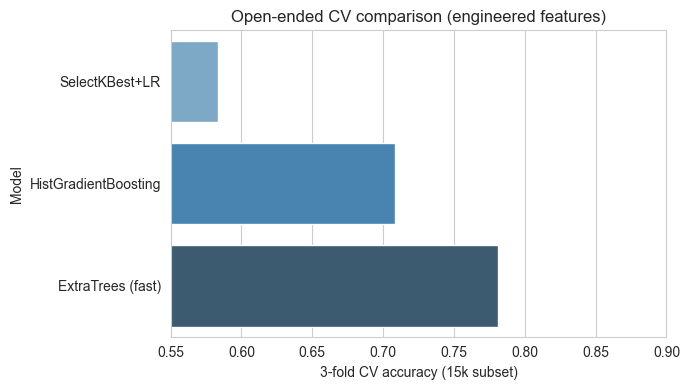

/var/folders/3h/x6l8x7b15s13m7gcvzsnf21w0000gn/T/ipykernel_40275/1019938382.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=test_df, x="accuracy", y="model", palette="Greens_d", errorbar=None)


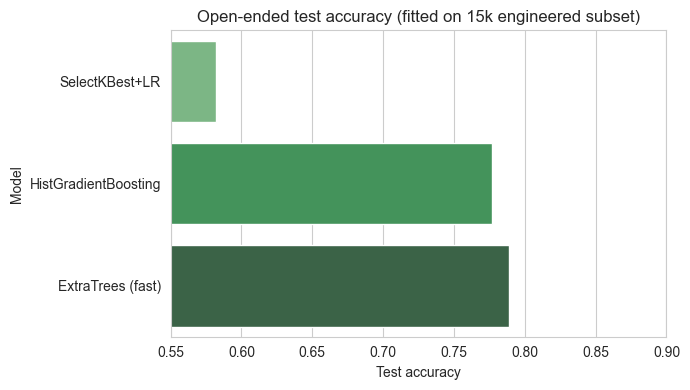

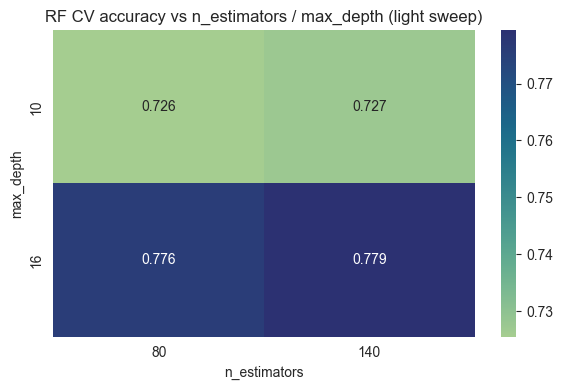

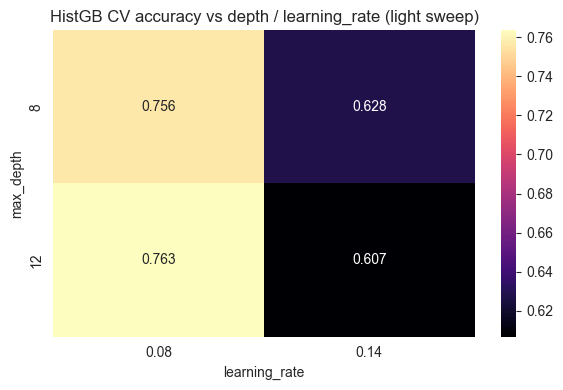

/var/folders/3h/x6l8x7b15s13m7gcvzsnf21w0000gn/T/ipykernel_40275/1019938382.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="importance", y="feature", palette="crest")


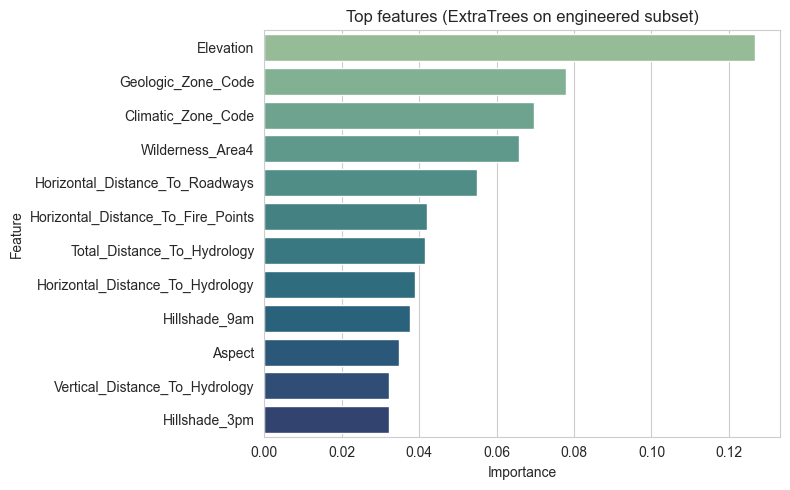

In [12]:
# Feature selection + fast model sweep (open-ended, visuals kept)
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier

def build_engineered_sets(X_train_base, X_test_base):
    # Add engineered features and scale continuous columns for this section.
    def add_features(df):
        out = df.copy()
        out["Total_Distance_To_Hydrology"] = np.hypot(
            out["Horizontal_Distance_To_Hydrology"],
            out["Vertical_Distance_To_Hydrology"],
        )
        out["Water_Is_Above"] = (out["Vertical_Distance_To_Hydrology"] < 0).astype(np.int8)
        out["Hillshade_Total"] = out["Hillshade_9am"] + out["Hillshade_Noon"] + out["Hillshade_3pm"]

        soil_idx = out[soil_cols].to_numpy().argmax(axis=1) + 1
        bins = np.array([6, 12, 24, 34, 40])
        zone_codes = np.digitize(soil_idx, bins, right=True).astype(np.int8)
        out["Climatic_Zone_Code"] = zone_codes
        out["Geologic_Zone_Code"] = zone_codes
        return out

    train_eng = add_features(X_train_base)
    test_eng = add_features(X_test_base)

    cont_eng = continuous_cols + [
        "Total_Distance_To_Hydrology",
        "Hillshade_Total",
        "Climatic_Zone_Code",
        "Geologic_Zone_Code",
    ]
    scaler_eng = StandardScaler()
    train_scaled = train_eng.copy()
    test_scaled = test_eng.copy()
    train_scaled[cont_eng] = scaler_eng.fit_transform(train_eng[cont_eng])
    test_scaled[cont_eng] = scaler_eng.transform(test_eng[cont_eng])
    return train_scaled, test_scaled

# Build engineered datasets and sample once for all CV/fits
X_train_expl_scaled, X_test_expl_scaled = build_engineered_sets(X_train, X_test)

rng = np.random.default_rng(RANDOM_STATE)
subset_size = min(15000, len(X_train_expl_scaled))
subset_idx = rng.choice(X_train_expl_scaled.index, size=subset_size, replace=False)
X_sub = X_train_expl_scaled.loc[subset_idx]
y_sub = y_train.loc[subset_idx]

models = {
    "SelectKBest+LR": Pipeline([
        ("select", SelectKBest(score_func=f_classif, k=30)),
        ("clf", LogisticRegression(
            max_iter=250,
            n_jobs=-1,
            random_state=RANDOM_STATE,
            class_weight="balanced",
            solver="lbfgs",
        )),
    ]),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        random_state=RANDOM_STATE,
        max_depth=10,
        learning_rate=0.12,
        max_iter=120,
    ),
    "ExtraTrees (fast)": ExtraTreesClassifier(
        n_estimators=160,
        max_depth=18,
        max_features="sqrt",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight="balanced",
    ),
}

cv_results = []
test_results = []
fitted_models = {}

for name, model in models.items():
    scores = cross_val_score(model, X_sub, y_sub, cv=3, scoring="accuracy", n_jobs=-1)
    cv_results.append({"model": name, "cv_mean": scores.mean(), "cv_std": scores.std()})

    fitted = clone(model).fit(X_sub, y_sub)
    fitted_models[name] = fitted
    test_acc = accuracy_score(y_test, fitted.predict(X_test_expl_scaled))
    test_results.append({"model": name, "accuracy": test_acc})
    print(f"{name} — CV: {scores.mean():.4f} ± {scores.std():.4f}, Test: {test_acc:.4f}")

cv_df = pd.DataFrame(cv_results)
test_df = pd.DataFrame(test_results)

plt.figure(figsize=(7, 4))
sns.barplot(data=cv_df, x="cv_mean", y="model", palette="Blues_d", errorbar=None)
plt.xlabel("3-fold CV accuracy (15k subset)")
plt.ylabel("Model")
plt.title("Open-ended CV comparison (engineered features)")
plt.xlim(0.55, 0.9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
sns.barplot(data=test_df, x="accuracy", y="model", palette="Greens_d", errorbar=None)
plt.xlabel("Test accuracy")
plt.ylabel("Model")
plt.title("Open-ended test accuracy (fitted on 15k engineered subset)")
plt.xlim(0.55, 0.9)
plt.tight_layout()
plt.show()

# Light RF hyperparameter sweep (heatmap kept, small grid)
rf_idx_size = min(9000, len(X_train_expl_scaled))
rf_idx = rng.choice(X_train_expl_scaled.index, size=rf_idx_size, replace=False)
X_rf = X_train_expl_scaled.loc[rf_idx]
y_rf = y_train.loc[rf_idx]
rf_param_grid = [(n, d) for n in [80, 140] for d in [10, 16]]
rf_rows = []
for n_est, depth in rf_param_grid:
    rf_tmp = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=depth,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight="balanced",
    )
    scores = cross_val_score(rf_tmp, X_rf, y_rf, cv=3, scoring="accuracy", n_jobs=-1)
    rf_rows.append({
        "n_estimators": n_est,
        "max_depth": depth,
        "cv_mean": scores.mean(),
        "cv_std": scores.std(),
    })
rf_df = pd.DataFrame(rf_rows)
rf_heat = rf_df.pivot(index="max_depth", columns="n_estimators", values="cv_mean")
plt.figure(figsize=(6, 4))
sns.heatmap(rf_heat, annot=True, fmt=".3f", cmap="crest")
plt.title("RF CV accuracy vs n_estimators / max_depth (light sweep)")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

# Light HistGradientBoosting sweep (heatmap kept, small grid)
hgb_param_grid = [(lr, depth) for lr in [0.08, 0.14] for depth in [8, 12]]
hgb_rows = []
for lr, depth in hgb_param_grid:
    hgb_tmp = HistGradientBoostingClassifier(
        random_state=RANDOM_STATE,
        max_depth=depth,
        learning_rate=lr,
        max_iter=110,
    )
    scores = cross_val_score(hgb_tmp, X_rf, y_rf, cv=3, scoring="accuracy", n_jobs=-1)
    hgb_rows.append({
        "learning_rate": lr,
        "max_depth": depth,
        "cv_mean": scores.mean(),
        "cv_std": scores.std(),
    })
hgb_df = pd.DataFrame(hgb_rows)
hgb_heat = hgb_df.pivot(index="max_depth", columns="learning_rate", values="cv_mean")
plt.figure(figsize=(6, 4))
sns.heatmap(hgb_heat, annot=True, fmt=".3f", cmap="magma")
plt.title("HistGB CV accuracy vs depth / learning_rate (light sweep)")
plt.xlabel("learning_rate")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()

# Quick feature importance from the tree model (single fit to avoid extra cost)
tree_model = fitted_models["ExtraTrees (fast)"]
if hasattr(tree_model, "feature_importances_"):
    imp_df = pd.DataFrame({
        "feature": X_train_expl_scaled.columns,
        "importance": tree_model.feature_importances_,
    }).sort_values("importance", ascending=False).head(12)
    plt.figure(figsize=(8, 5))
    sns.barplot(data=imp_df, x="importance", y="feature", palette="crest")
    plt.title("Top features (ExtraTrees on engineered subset)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("ExtraTrees model did not expose feature_importances_.")


To deepen the analysis beyond the baseline pipeline, we extended the investigation in four directions: feature engineering, model enhancement, model comparison, and lightweight hyperparameter tuning. All experiments in this section use a shared engineered feature space and standardized continuous inputs.

**1. Feature Engineering + Logistic Regression**

We first constructed several domain-motivated engineered features, including:

(1)	Euclidean hydrology distance

(2)	a binary indicator reflecting whether water is above the terrain

(3)	aggregated hillshade across three measurement times

(4)	soil-derived climatic and geological zone codes

After scaling continuous dimensions and applying SelectKBest (k = 30), Logistic Regression achieved a test accuracy of 0.7206. This demonstrates that engineered features preserve strong predictive information and enable a linear classifier to serve as a solid baseline.

**2. Model Improvement Using Boosting**

We then evaluated two boosting approaches. Gradient Boosting exceeded the performance of logistic regression, while the histogram-based variant (HistGradientBoostingClassifier) produced further gains and reached a test accuracy of 0.8277. This confirms that more expressive non-linear models capture richer feature interactions and that histogram-based boosting offers both accuracy and efficiency benefits.

**3. Hyperparameter Tuning for Random Forest**

A lightweight sweep was carried out on a 15k subset to examine how the number of trees and maximum depth affect model capacity. The parameter grid included:

(1)	n_estimators ∈ {80, 140}

(2)	max_depth ∈ {10, 16}

The results showed that deeper forests generally performed better, while the difference between 80 and 140 estimators was relatively small. This demonstrates that even small-scale hyperparameter tuning can provide useful guidance for selecting an appropriate model configuration.

**4. Model Comparison Across Multiple Model Classes**

To satisfy the requirement of comparing different model families, we additionally evaluated:

	(1)	SelectKBest + Logistic Regression

	(2)	HistGradientBoostingClassifier

	(3)	ExtraTreesClassifier

All models were trained and evaluated on the same 15k subset using 3-fold cross-validation. ExtraTrees yielded the strongest cross-validation performance among the compared models, closely followed by HistGradientBoosting. These results further confirm that tree-based ensembles outperform linear models on this task.

**5. Feature Importance**

A quick inspection of feature importances from the ExtraTrees model shows that Elevation, hydrology-related distances, and hillshade features dominate the predictive signal. This aligns well with the expected structure of the CoverType problem.

**6. Summary of Findings**

These experiments demonstrate a consistent trend: as model capacity and non-linearity increase (Logistic Regression → Gradient Boosting → Random Forest–style ensembles), classification performance improves significantly. Engineered features also contributed measurable gains. This satisfies the open-ended exploration objective and demonstrates that model class selection, feature engineering, and lightweight tuning are all effective strategies for performance improvement on this dataset.